        JACOB KNOPPING
        1/21/2020
        
# 18.8 Challenge
In this module, we learned how to approach and solve regression problems using linear regression models. Throughout the module, you worked on a house price dataset from Kaggle. In this challenge, you will keep working on this dataset.

## The scenario
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

## Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

# Solution

#### Step 1: Load the houseprices data from Thinkful's database.

In [1]:
# import the relevant libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
#load the data from the PostgreSQL database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

#no need for an open connection (just the one query)
engine.dispose()

#view first 5 rows
houseprices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


#### Step 2: Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

_Data Cleaning: Missing values and Outliers_

In [3]:
houseprices_df.shape

(1460, 81)

In [4]:
#Some columns are non-numerical
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print('Non-numeric columns:', len(non_numeric_columns))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
Non-numeric columns: 43


In [5]:
numeric_columns = houseprices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("Numeric columns:", len(numeric_columns))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Numeric columns: 38


Roughly half of the data is non-numeric (43 non-numeric columns compared to 38 numeric).

In [6]:
#Missing data
pd.options.display.max_rows = houseprices_df.shape[1]

total_missing = houseprices_df.isnull().sum()
total_count = houseprices_df.isnull().count()
percent_missing = 100*total_missing/total_count
print(percent_missing)

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfinsf1        0.000000
bsmtfintype2      2.602740
bsmtfinsf2        0.000000
b

In [7]:
#drop variables with significant amounts of missing data
houseprices_copy = houseprices_df.copy()

houseprices_df.drop(['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature'], axis=1, inplace=True)

total_missing = houseprices_df.isnull().sum()
total_count = houseprices_df.isnull().count()
percent_missing = 100*total_missing/total_count
print(percent_missing)

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfinsf1        0.000000
bsmtfintype2      2.602740
bsmtfinsf2        0.000000
bsmtunfsf         0.000000
t

In [8]:
#interpolate continuous (numeric) variables with small amounts of missing data
fill_list = list(houseprices_df.columns)

for column in fill_list:
    houseprices_df[column].interpolate(inplace=True)

#fill missing categorical (non-numeric) variables with mode
houseprices_df = houseprices_df.fillna(houseprices_df.mode().iloc[0])
    
houseprices_df.isnull().sum()

id               0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
lotshape         0
landcontour      0
utilities        0
lotconfig        0
landslope        0
neighborhood     0
condition1       0
condition2       0
bldgtype         0
housestyle       0
overallqual      0
overallcond      0
yearbuilt        0
yearremodadd     0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
masvnrarea       0
exterqual        0
extercond        0
foundation       0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfinsf1       0
bsmtfintype2     0
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
heating          0
heatingqc        0
centralair       0
electrical       0
firstflrsf       0
secondflrsf      0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
kitchenqual 

There are no missing values remaining.

_EDA and Feature Engineering_

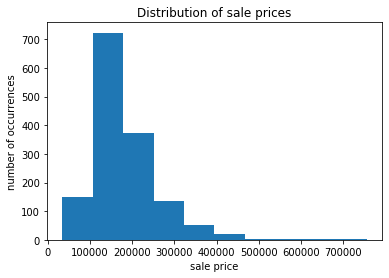

Skewness: 1.8828757597682129
Kurtosis: 6.5362818600645305


In [9]:
#Exploring distribution
plt.hist(houseprices_df.saleprice)
plt.title("Distribution of sale prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")
plt.show()

print('Skewness:', houseprices_df.saleprice.skew())
print('Kurtosis:', houseprices_df.saleprice.kurt())

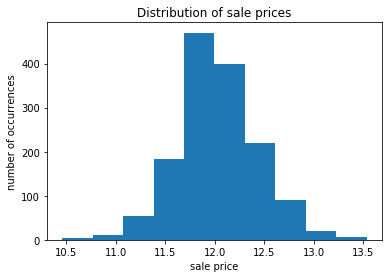

Skewness: 0.12134661989685337
Kurtosis: 0.8095191557078794


NormaltestResult(statistic=25.507181803362418, pvalue=2.8919171511318266e-06)

In [10]:
#Exploring distribution of log transformed saleprice
plt.hist(np.log1p(houseprices_df.saleprice))
plt.title("Distribution of sale prices")
plt.xlabel("sale price")
plt.ylabel("number of occurrences")
plt.show()

from scipy import stats
print('Skewness:', np.log1p(houseprices_df.saleprice).skew())
print('Kurtosis:', np.log1p(houseprices_df.saleprice).kurt())
stats.normaltest(np.log1p(houseprices_df.saleprice))

The distribution of saleprice is non-normal (skewed to the right). This may prove significant when building a regression model. A log transform of the target variable may prove useful later on, as this distribution is closer to normal.

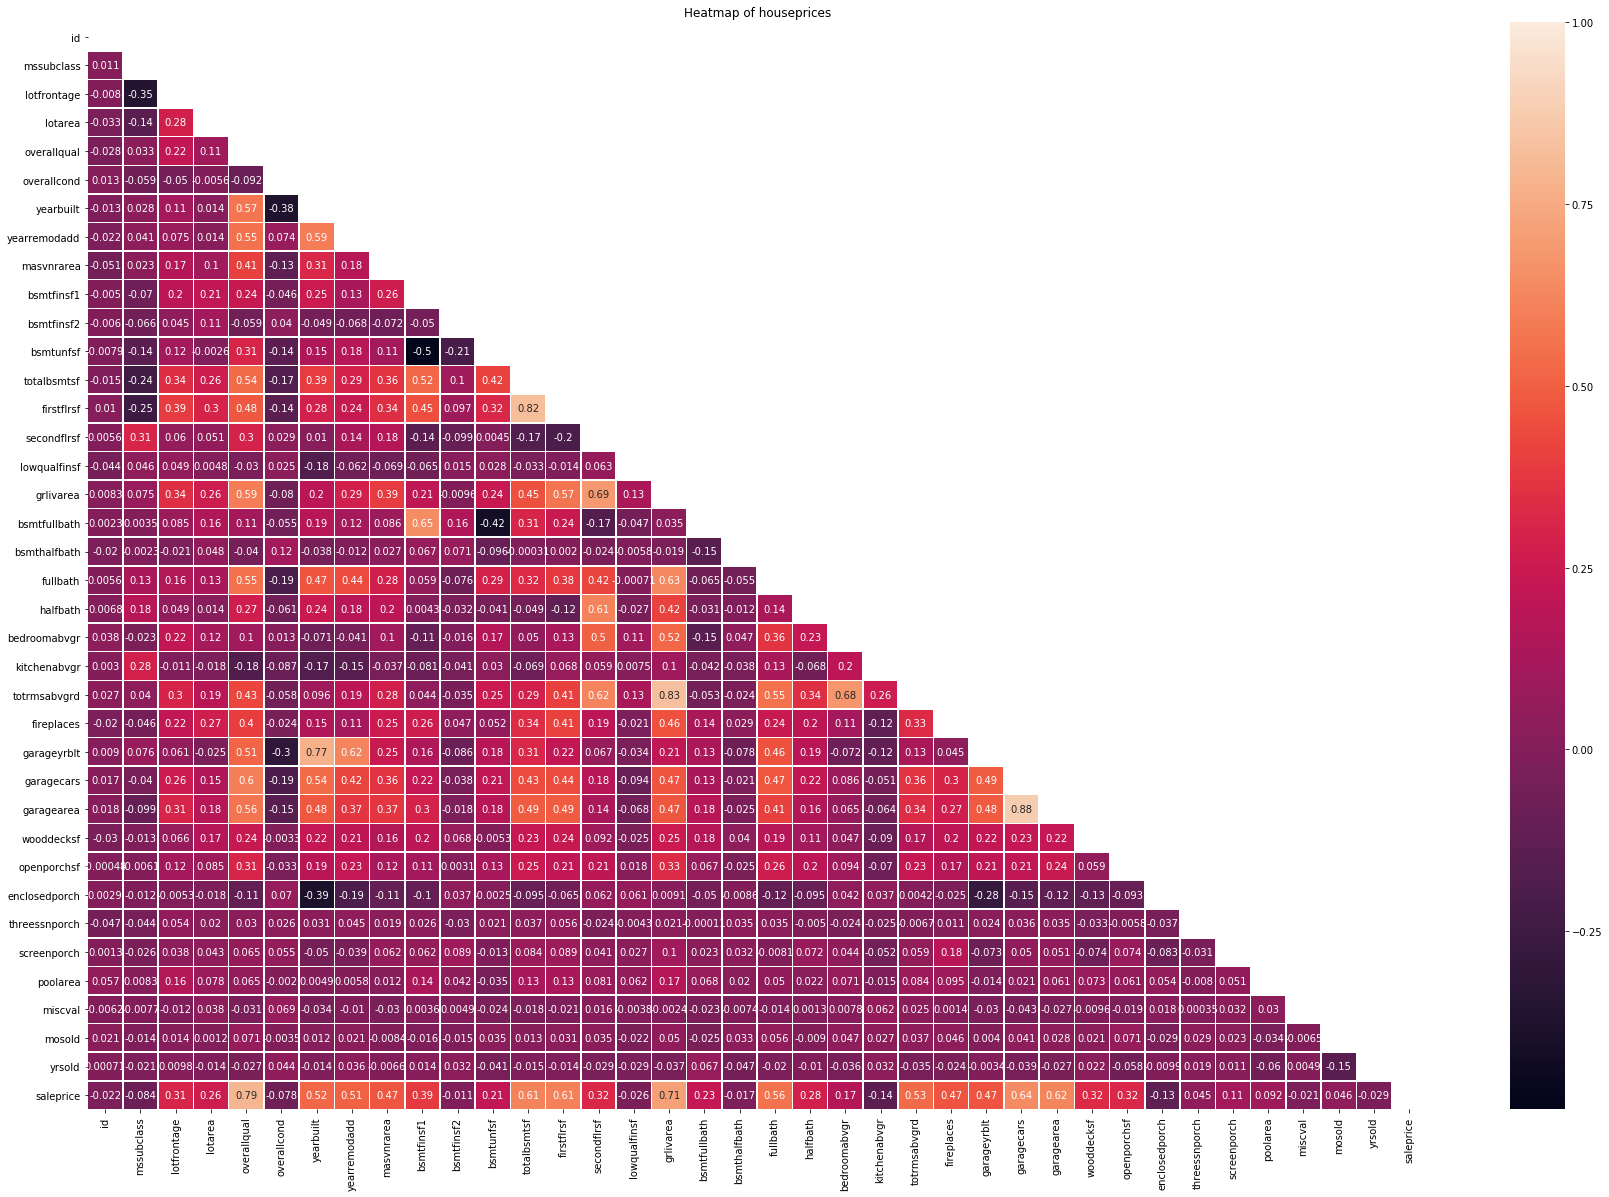

In [11]:
#Create a heatmap of all numeric data
corr = houseprices_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,20))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5)
plt.title('Heatmap of houseprices')
plt.show()

In [12]:
np.abs(houseprices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.474279
garageyrblt      0.467106
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
lotfrontage      0.310557
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Based on the heatmap and the descending list showing correlations, saleprices can be represented as a function of:

    overallqual 
    grlivarea
    garagecars or garagearea (high correlation of 0.88)
    totalbsmtsf or firstflrsf (high correlation of 0.82)
    
These are the variables with the strongest correlations (corr >= 0.6).

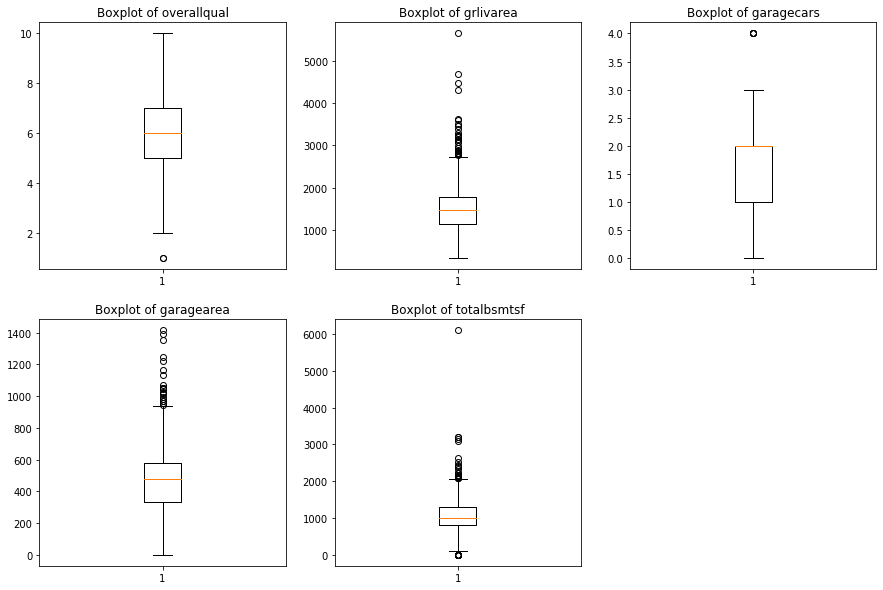

In [13]:
#Checking for potential outliers in features
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.boxplot(houseprices_df['overallqual'])
plt.title("Boxplot of overallqual")

plt.subplot(2,3,2)
plt.boxplot(houseprices_df['grlivarea'])
plt.title("Boxplot of grlivarea")

plt.subplot(2,3,3)
plt.boxplot(houseprices_df['garagecars'])
plt.title("Boxplot of garagecars")

plt.subplot(2,3,4)
plt.boxplot(houseprices_df['garagearea'])
plt.title("Boxplot of garagearea")

plt.subplot(2,3,5)
plt.boxplot(houseprices_df['totalbsmtsf'])
plt.title("Boxplot of totalbsmtsf")
    
plt.show()

There are potential outliers for each of these variables. Use winsorization to handle these outliers.

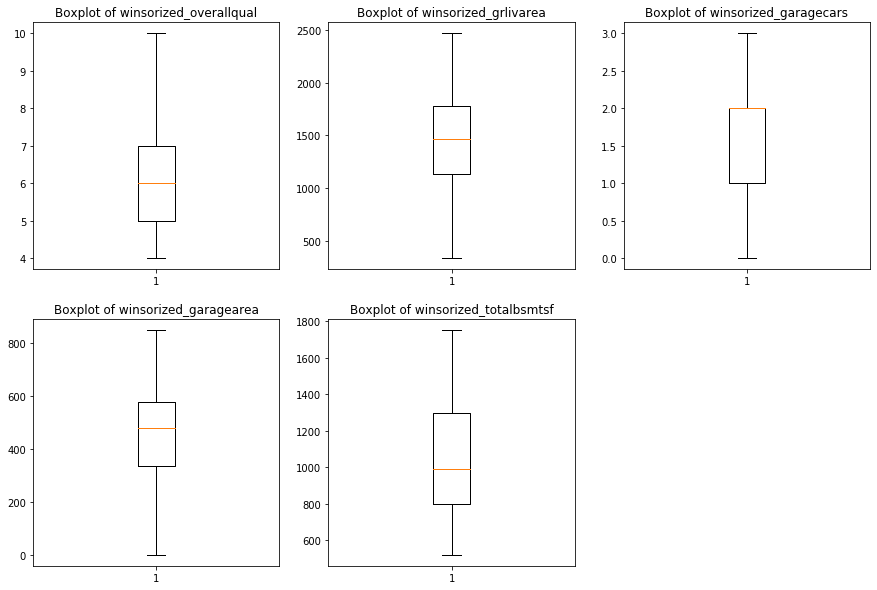

In [14]:
#Apply winsorization

from scipy.stats.mstats import winsorize

houseprices_df['winsorized_overallqual'] = winsorize(houseprices_df.overallqual, (0.05, 0.00))
houseprices_df['winsorized_grlivarea'] = winsorize(houseprices_df.grlivarea, (0.00, 0.05))
houseprices_df['winsorized_garagecars'] = winsorize(houseprices_df.garagecars, (0.00, 0.05))
houseprices_df['winsorized_garagearea'] = winsorize(houseprices_df.garagearea, (0.00, 0.05))
houseprices_df['winsorized_totalbsmtsf'] = winsorize(houseprices_df.totalbsmtsf, (0.05, 0.05))


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.boxplot(houseprices_df['winsorized_overallqual'])
plt.title("Boxplot of winsorized_overallqual")

plt.subplot(2,3,2)
plt.boxplot(houseprices_df['winsorized_grlivarea'])
plt.title("Boxplot of winsorized_grlivarea")

plt.subplot(2,3,3)
plt.boxplot(houseprices_df['winsorized_garagecars'])
plt.title("Boxplot of winsorized_garagecars")

plt.subplot(2,3,4)
plt.boxplot(houseprices_df['winsorized_garagearea'])
plt.title("Boxplot of winsorized_garagearea")

plt.subplot(2,3,5)
plt.boxplot(houseprices_df['winsorized_totalbsmtsf'])
plt.title("Boxplot of winsorized_totalbsmtsf")
    
plt.show()

No outliers remain in these potential feature variables.

In [15]:
#need to update non-numeric columns(those with very large amounts of missing data were dropped)
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(len(non_numeric_columns))

38


Now it's time to account for non-numeric data.

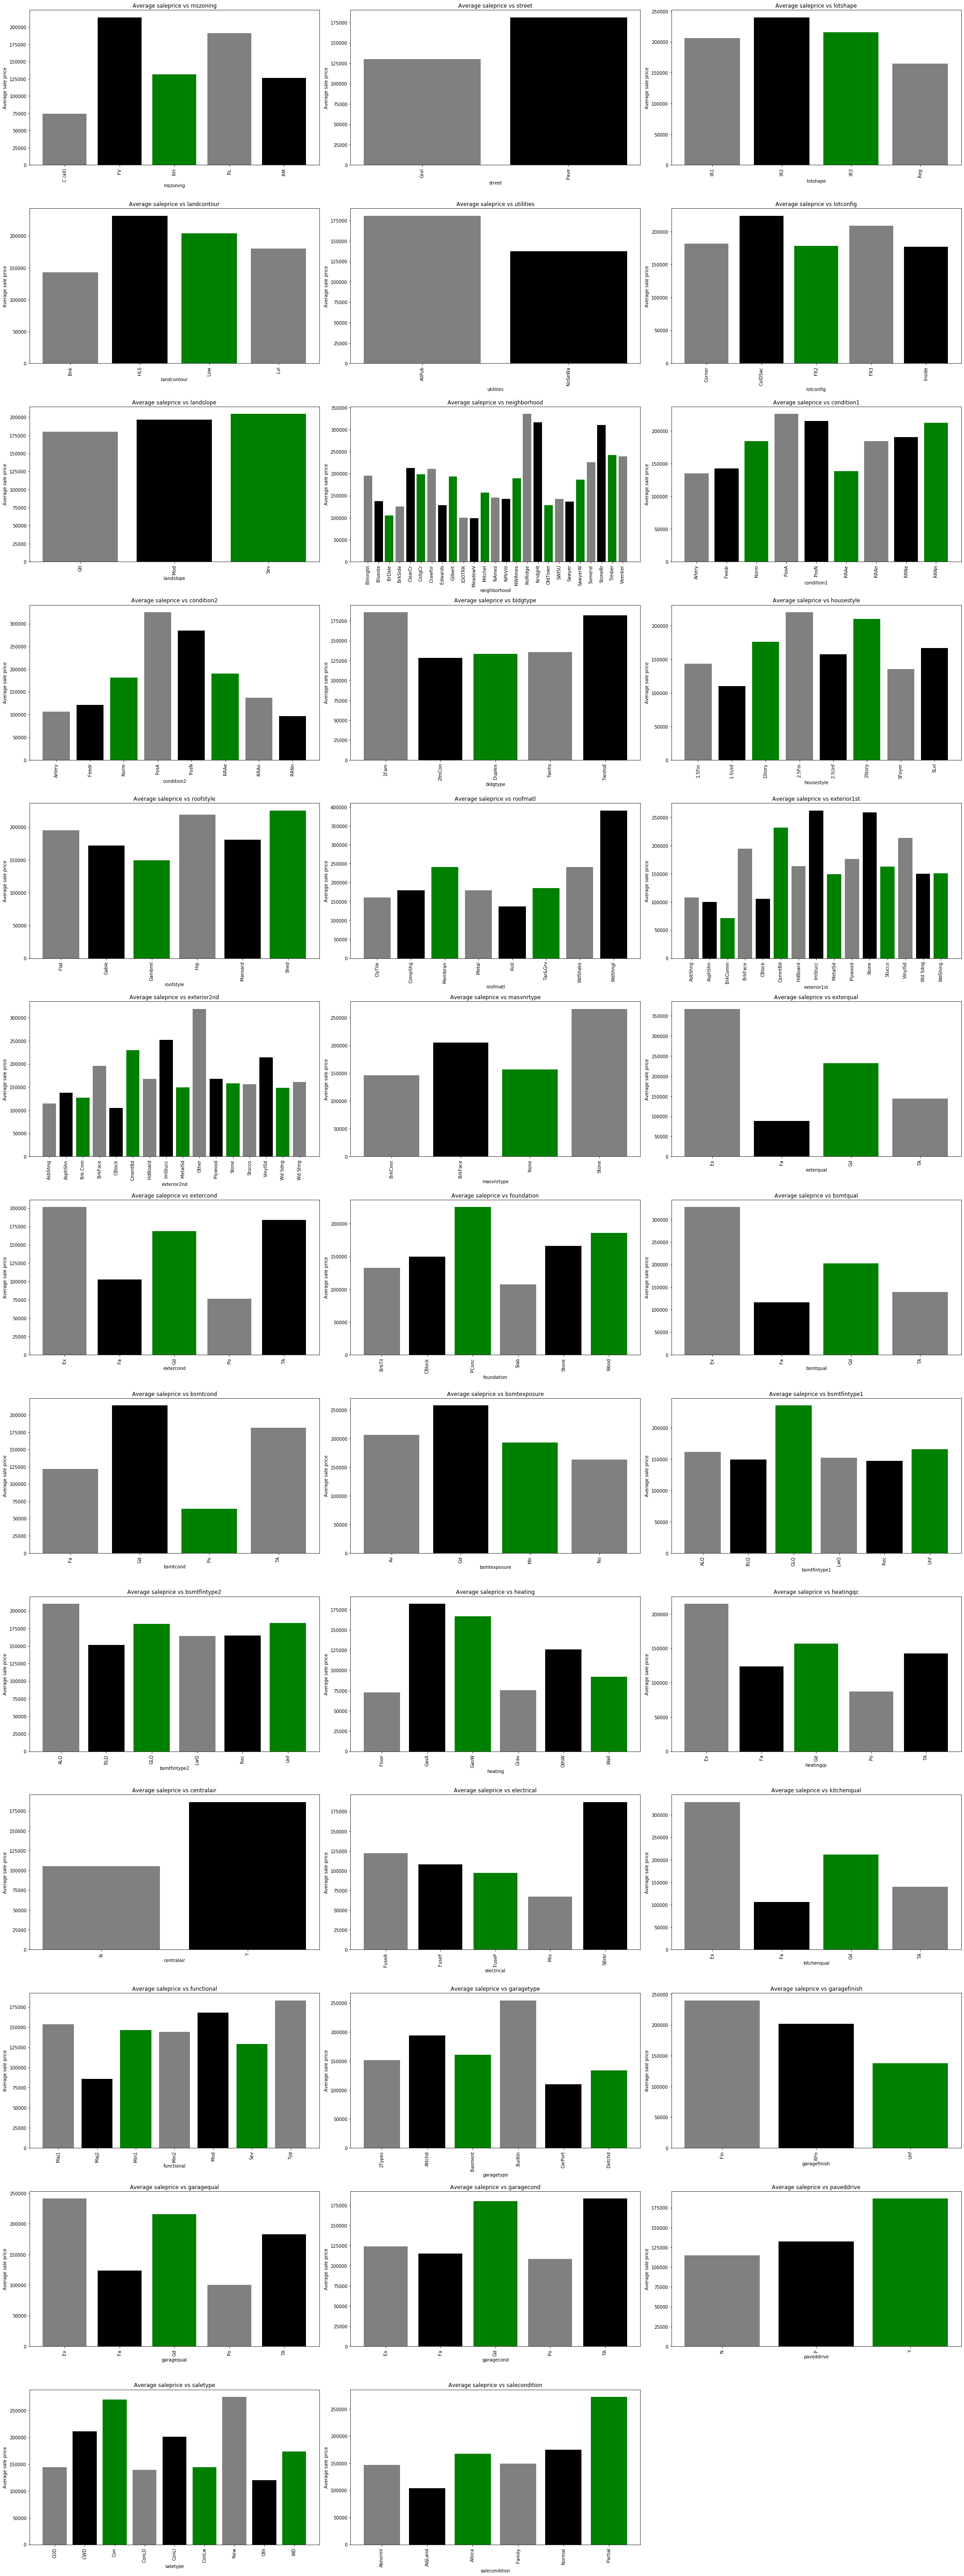

In [16]:
#Visual all non-numeric/categorocal data

plt.figure(figsize=(30,80))

for index, column in enumerate(non_numeric_columns):
    #There are now 38 non-numeric columns
    plt.subplot(13,3,index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index,
            houseprices_df.groupby(column)['saleprice'].mean(), 
            color=('gray','black', 'green'))
    plt.title("Average saleprice vs {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

From these graphs, it is apparent that a lot of the non-numeric data has significant impact on saleprices (which will be the target variable). Some the most notable include: mszoning, street, utilities, neighborhood, exterqual, and kitchenqual. Based on numeric and non-numeric features, saleprices can be represented as a function of:

    winsorized_overallqual 
    winsorized_grlivarea
    winsorized_garagecars or winsorized_garagearea
    winsorized_totalbsmtsf

    mszoning
    street
    utilities
    neighborhood
    exterqual
    kitchenqual

#### Step 3: Now, split your data into train and test sets where 20% of the data resides in the test set.

_Buidling the model_

In [17]:
#Selecting the features for categorical variables as a dummy list
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.utilities, prefix="utilities", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.exterqual, prefix="exterqual", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.kitchenqual, prefix="kitchenqual", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.utilities, prefix="utilities", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.neighborhood, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.exterqual, prefix="exterqual", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.kitchenqual, prefix="kitchenqual", drop_first=True).columns)

In [18]:
#MODEL A

#Feature set(X)
X = houseprices_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names]
#Target variable(Y)
Y = houseprices_df.saleprice

#Train and test sets (20% of the data resides in the test set)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#Add constant
X_train = sm.add_constant(X_train)
#Fit OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()
#Print results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     146.7
Date:                Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:12:27   Log-Likelihood:                -13759.
No. Observations:                1168   AIC:                         2.760e+04
Df Residuals:                    1127   BIC:                         2.781e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.429e+04   2.57e+04     -0.944      0.345   -7.48e+04    2.62e+04
winsorized_overallqual  1.473e+04   1365.008     10.794      0.000    1.21e+04    1.74e+04
winsorized_grlivarea      46.7874      2.916     16.043      0.000      41.065      52.510
winsorized_garagecars   1.202e+04   1853.535      6.484      0.000    8381.443    1.57e+04
winsorized_totalbsmtsf    34.4085      3.671      9.373      0.000      27.206      41.611
mszoning_FV             4.006e+04   1.69e+04      2.377      0.018    6994.128    7.31e+04
mszoning_RH             2.941e+04   1.68e+04      1.754      0.080   -3483.394    6.23e+04
mszoning_RL             3.972e+04    1.4e+04      2.832      0.005    1.22e+04    6.72e+04
mszoning_RM             2.566e+04   1.32e+04      1.938      0.053    -317.978    5.16e+04
street_Pave            -2005.8586   1.56e+04     -0.129      0.898   -3.26e+04    2.85e+04
utilities_NoSeWa        -4.74e+04   3.28e+04     -1.443      0.149   -1.12e+05     1.7e+04
neighborhood_Blueste     1.11e+04   2.52e+04      0.441      0.659   -3.83e+04    6.05e+04
neighborhood_BrDale     5456.4006   1.38e+04      0.395      0.693   -2.17e+04    3.26e+04
neighborhood_BrkSide    1.693e+04    1.1e+04      1.541      0.124   -4628.717    3.85e+04
neighborhood_ClearCr    2.633e+04   1.13e+04      2.328      0.020    4142.853    4.85e+04
neighborhood_CollgCr    1.902e+04   9240.634      2.058      0.040     888.367    3.71e+04
neighborhood_Crawfor    3.709e+04   1.04e+04      3.579      0.000    1.68e+04    5.74e+04
neighborhood_Edwards    2508.5606   1.01e+04      0.249      0.803   -1.72e+04    2.23e+04
neighborhood_Gilbert    1.787e+04   9829.683      1.818      0.069   -1418.297    3.72e+04
neighborhood_IDOTRR     1.515e+04   1.32e+04      1.148      0.251   -1.07e+04     4.1e+04
neighborhood_MeadowV    2.197e+04   1.38e+04      1.589      0.112   -5162.364    4.91e+04
neighborhood_Mitchel     1.04e+04   1.06e+04      0.983      0.326   -1.04e+04    3.12e+04
neighborhood_NAmes      1.015e+04   9514.352      1.066      0.286   -8522.183    2.88e+04
neighborhood_NPkVill   -2672.8295    1.6e+04     -0.167      0.868   -3.41e+04    2.88e+04
neighborhood_NWAmes     5219.9331      1e+04      0.521      0.603   -1.44e+04    2.49e+04
neighborhood_NoRidge    8.343e+04   1.05e+04      7.930      0.000    6.28e+04    1.04e+05
neighborhood_NridgHt     4.58e+04   9745.233      4.700      0.000    2.67e+04    6.49e+04
neighborhood_OldTown    3237.4054   1.09e+04      0.297      0.766   -1.81e+04    2.46e+04
neighborhood_SWISU     -2697.2537   1.19e+04     -0.226      0.821   -2.61e+04    2.07e+04
neighborhood_Sawyer     1.138e+04   1.02e+04      1.121      0.263   -8549.282    3.13e+04
neighborhood_SawyerW    1.256e+04   1.01e+04      1.244      0.214   -7243.849  

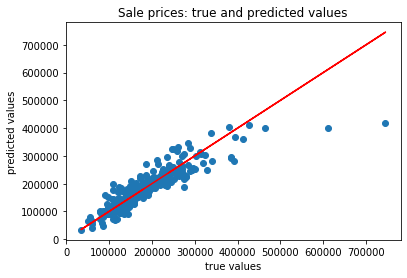

Mean absolute error of the prediction is: 23204.68781712969
Mean squared error of the prediction is: 1385096323.475839
Root mean squared error of the prediction is: 37216.882237444865
Mean absolute percentage error of the prediction is: 12.844274212385493


In [19]:
#Add a constant
X_test = sm.add_constant(X_test)

#Make predictions using predict() function
y_preds = results.predict(X_test)

#Model graph
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title('Sale prices: true and predicted values')
plt.show()

#Evaluation metrics
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [20]:
#MODEL B

#Feature set(X)
X = houseprices_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names]
#Log transform the target variable(Y)
Y = np.log1p(houseprices_df.saleprice)

#Train and test sets (20% of the data resides in the test set)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#Add constant
X_train = sm.add_constant(X_train)
#Fit OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()
#Print results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     180.0
Date:                Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:12:27   Log-Likelihood:                 589.77
No. Observations:                1168   AIC:                            -1098.
Df Residuals:                    1127   BIC:                            -889.9
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.6234      0.119     89.382      0.000      10.390      10.857
winsorized_overallqual     0.0792      0.006     12.563      0.000       0.067       0.092
winsorized_grlivarea       0.0003   1.35e-05     19.717      0.000       0.000       0.000
winsorized_garagecars      0.0703      0.009      8.215      0.000       0.054       0.087
winsorized_totalbsmtsf     0.0002    1.7e-05     10.717      0.000       0.000       0.000
mszoning_FV                0.4196      0.078      5.390      0.000       0.267       0.572
mszoning_RH                0.3078      0.077      3.974      0.000       0.156       0.460
mszoning_RL                0.3863      0.065      5.961      0.000       0.259       0.513
mszoning_RM                0.3138      0.061      5.130      0.000       0.194       0.434
street_Pave               -0.1018      0.072     -1.416      0.157      -0.243       0.039
utilities_NoSeWa          -0.2338      0.152     -1.541      0.124      -0.531       0.064
neighborhood_Blueste       0.0360      0.116      0.310      0.757      -0.192       0.264
neighborhood_BrDale       -0.0880      0.064     -1.378      0.168      -0.213       0.037
neighborhood_BrkSide       0.0165      0.051      0.325      0.745      -0.083       0.116
neighborhood_ClearCr       0.1362      0.052      2.607      0.009       0.034       0.239
neighborhood_CollgCr       0.0875      0.043      2.049      0.041       0.004       0.171
neighborhood_Crawfor       0.1739      0.048      3.632      0.000       0.080       0.268
neighborhood_Edwards      -0.0488      0.047     -1.049      0.295      -0.140       0.042
neighborhood_Gilbert       0.0949      0.045      2.090      0.037       0.006       0.184
neighborhood_IDOTRR       -0.0468      0.061     -0.768      0.442      -0.166       0.073
neighborhood_MeadowV      -0.0396      0.064     -0.620      0.535      -0.165       0.086
neighborhood_Mitchel       0.0421      0.049      0.861      0.389      -0.054       0.138
neighborhood_NAmes         0.0377      0.044      0.857      0.391      -0.049       0.124
neighborhood_NPkVill      -0.0254      0.074     -0.343      0.732      -0.171       0.120
neighborhood_NWAmes        0.0291      0.046      0.629      0.530      -0.062       0.120
neighborhood_NoRidge       0.2033      0.049      4.182      0.000       0.108       0.299
neighborhood_NridgHt       0.1497      0.045      3.325      0.001       0.061       0.238
neighborhood_OldTown      -0.0788      0.050     -1.566      0.118      -0.178       0.020
neighborhood_SWISU        -0.0206      0.055     -0.373      0.709      -0.129       0.088
neighborhood_Sawyer        0.0310      0.047      0.660      0.509      -0.061       0.123
neighborhood_SawyerW       0.0406      0.047      0.872      0.384      -0.051  

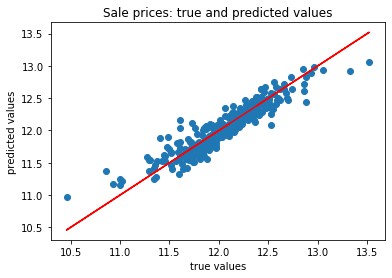

Mean absolute error of the prediction is: 0.11330083492151033
Mean squared error of the prediction is: 0.02282991261840647
Root mean squared error of the prediction is: 0.15109570681659512
Mean absolute percentage error of the prediction is: 0.9473702255283273


In [21]:
#Add a constant
X_test = sm.add_constant(X_test)

#Make predictions using predict() function
y_preds = results.predict(X_test)

#Model graph
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title('Sale prices: true and predicted values')
plt.show()

#Evaluation metrics
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

For almost all metrics, the test set performance is Model B (which log transformed the target variable, saleprice) is better than Model A. For Model B, the Adj. R-squared value was higher (.860 vs .833), and evaluation metrics (MAE, MSE, RMSE, MAPE) were all lower (indicative of better performance). Both AIC and BIC scores are also significantly lower for Model B than Model A. In addition, Model A predicts lower values better than higher values. However, Model B more evenly and accurately predicts all values. 

Model B appears to be the right choice, based on visual and statistical performance. The following models will be variations of Model B.

#### Step 4: Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

#### AND

#### Step 5:  Evaluate your best model on the test set.

Now we will build the following linear regression models, that will use k-fold cross-validation to select the best hyperparamaters:
* OLS Regression (same as Model B from before): minimizes the sum of least squares, the differences between predicted values and observed values
* Ridge Regression: consists of the OLS function, except it includes regularization based on the sum of the squared weights (L2 regularization)
* Lasso Regression: also consists of the OLS function, but it includes regularization based on the sum of the absolute weights (L1 regularization)
* Elastic Net Regression: a popular method that combines both Lasso's L1 regularization and Ridge's L2 regularization

In [22]:
#OLS Regression Model

#Feature set(X)
X = houseprices_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names]
#Log transform the target variable(Y)
Y = np.log1p(houseprices_df.saleprice)

#Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8646568780369258
-----Test set statistics-----
R-squared of the model in the test set is: 0.8630854071431089
Mean absolute error of the prediction is: 0.1133008349216371
Mean squared error of the prediction is: 0.02282991261842369
Root mean squared error of the prediction is: 0.1510957068166521
Mean absolute percentage error of the prediction is: 0.9473702255293278


In [23]:
#Ridge Regression Model

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

#fitting a ridge regression model
#alpha is regularization parameter, here (usually called lamda, which doesn't
#work in python because it is a keyword!)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8637673365967764
-----Test set statistics-----
R-squared of the model in test set is: 0.8587829700406089
Mean absolute error of the prediction is: 0.11438904815466043
Mean squared error of the prediction is: 0.02354732528457393
Root mean squared error of the prediction is: 0.15345137759099436
Mean absolute percentage error of the prediction is: 0.9572076490906779


In [24]:
#Lasso Regression Model
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8641632254524528
-----Test set statistics-----
R-squared of the model in test set is: 0.8598082216321428
Mean absolute error of the prediction is: 0.11413124342757196
Mean squared error of the prediction is: 0.023376369042743043
Root mean squared error of the prediction is: 0.152893325697177
Mean absolute percentage error of the prediction is: 0.9547201754973095


In [25]:
#Elastic Net Regression Model
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.864449493441301
-----Test set statistics-----
R-squared of the model in test set is: 0.8611366642899303
Mean absolute error of the prediction is: 0.11372265608339417
Mean squared error of the prediction is: 0.02315485700985423
Root mean squared error of the prediction is: 0.15216720083465501
Mean absolute percentage error of the prediction is: 0.9511584841466773


The best model is the OLS regression model, as that is the model with highest R-squared value. Additionally, MAE, MSE, RMSE, and MAPE are all lowest for the the OLS model. 

#### Step 6: So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

Interest rates at the time a house is sold could have an impact on saleprice. In order to evaluate the impact of this new data on our model, a new csv file is obtained from Kaggle (https://www.kaggle.com/federalreserve/interest-rates/data).

In [26]:
#upload dataframe containing interest rate data
int_rates_df = pd.read_csv('interest_rates.csv')

In [27]:
int_rates_df.head(5)

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [28]:
#df.rename(columns={"A": "a", "B": "c"})
int_rates_df.rename(columns={"Month": "mosold", "Year": "yrsold"}, inplace=True)
int_rates_df.head(5)

,yrsold,mosold,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [29]:
pd.options.display.max_columns = None
houseprices_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,winsorized_overallqual,winsorized_grlivarea,winsorized_garagecars,winsorized_garagearea,winsorized_totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,utilities_NoSeWa,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,exterqual_Fa,exterqual_Gd,exterqual_TA,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,7,1710,2,548,856,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,6,1262,2,460,1262,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,7,1786,2,608,920,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,7,1717,3,642,756,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,8,2198,3,836,1145,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [30]:
#Integrate interest rate into houseprices dataframe
combined_houses_df = pd.merge(houseprices_df, int_rates_df, on=['mosold', 'yrsold'])
combined_houses_df.rename(columns={"Effective Federal Funds Rate": "eff_int_rate"}, inplace=True)
combined_houses_df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,winsorized_overallqual,winsorized_grlivarea,winsorized_garagecars,winsorized_garagearea,winsorized_totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,utilities_NoSeWa,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,exterqual_Fa,exterqual_Gd,exterqual_TA,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,eff_int_rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,7,1710,2,548,856,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
1,11,20,RL,70.0,11200,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,906,Unf,0,134,1040,GasA,Ex,Y,SBrkr,1040,0,0,1040,1,0,1,0,3,1,TA,5,Typ,0,Detchd,1965.0,Unf,1,384,TA,TA,Y,0,0,0,0,0,0,0,2,2008,WD,Normal,129500,5,1040,1,384,1040,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
2,202,20,RL,75.0,10125,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,641,LwQ,279,276,1196,GasA,TA,Y,SBrkr,1279,0,0,1279,0,1,2,0,3,1,TA,6,Typ,2,Detchd,1980.0,Unf,2,473,TA,TA,Y,238,83,0,0,0,0,0,2,2008,WD,Normal,171500,6,1279,2,473,1196,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
3,269,30,RM,71.0,6900,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,6,1940,1955,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,403,Rec,125,212,740,GasA,Ex,Y,SBrkr,778,0,0,778,0,0,1,0,2,1,TA,4,Typ,1,Detchd,1966.0,Fin,1,924,Ex,Ex,Y,0,25,0,0,0,0,0,2,2008,WD,Normal,120500,5,778,1,850,740,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3
4,423,20,RL,100.0,21750,Pave,Reg,HLS,AllPub,Inside,Mod,Mitchel,Artery,Norm,1Fam,1Story,5,5,1954,1954,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,988,988,GasA,Ex,Y,FuseA,988,0,0,988,0,0,1,0,2,1,TA,4,Typ,0,Attchd,1954.0,RFn,2,520,TA,TA,N,0,0,0,0,0,0,0,2,2008,WD,Normal,113000,5,988,2,520,988,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,3.0,NaN,NaN,2.98,NaN,4.9,2.3


In [31]:
corr_df = combined_houses_df[['eff_int_rate', 'saleprice']]
corr_df.corr()

,eff_int_rate,saleprice
eff_int_rate,1.000000,0.028148
saleprice,0.028148,1.000000


The correlation between interest rate and saleprice is very low, which means there will likely be little to no impact on our model. Perhaps another external variable, unemployment rate, will have a larger correlation.

In [32]:
combined_houses_df.rename(columns={'Unemployment Rate': 'unemployment_rate'}, inplace=True)

corr_df = combined_houses_df[['unemployment_rate', 'saleprice']]
corr_df.corr()

,unemployment_rate,saleprice
unemployment_rate,1.000000,-0.021941
saleprice,-0.021941,1.000000


Unemployment rate had a slightly lower correlation that interest rate. Neither external variable is predicted to have an impact on the model.

In [33]:
combined_houses_df.unemployment_rate.isnull().sum()

294

In [34]:
combined_houses_df.eff_int_rate.isnull().sum()

294

In [35]:
combined_houses_df = combined_houses_df.interpolate()

In [36]:
combined_houses_df.unemployment_rate.isnull().sum()

0

In [37]:
combined_houses_df.eff_int_rate.isnull().sum()

0

In [38]:
corr_df = combined_houses_df[['saleprice', 'eff_int_rate', 'unemployment_rate']]
corr_df.corr()

,saleprice,eff_int_rate,unemployment_rate
saleprice,1.000000,0.032400,-0.019773
eff_int_rate,0.032400,1.000000,-0.910737
unemployment_rate,-0.019773,-0.910737,1.000000


Unemployment rate and interest rate have a highly negative correlation, but little correlation to the target variable (saleprice). Because of their correlation, only interest rate is inlcuded in the model.

In [39]:
#Model with new external variables

#Feature set(X)
X = combined_houses_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf', 'eff_int_rate'] + dummy_column_names]
#Log transform the target variable(Y)
Y = np.log1p(combined_houses_df.saleprice)

#Train and test sets (20% of the data resides in the test set)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

#Add constant
X_train = sm.add_constant(X_train)
#Fit OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()
#Print results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     213.0
Date:                Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:12:30   Log-Likelihood:                 718.61
No. Observations:                1403   AIC:                            -1355.
Df Residuals:                    1362   BIC:                            -1140.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     10.8320      0.114     95.025      0.000      10.608      11.056
winsorized_overallqual     0.0743      0.006     13.218      0.000       0.063       0.085
winsorized_grlivarea       0.0003   1.21e-05     20.660      0.000       0.000       0.000
winsorized_garagecars      0.0721      0.008      9.401      0.000       0.057       0.087
winsorized_totalbsmtsf     0.0002   1.56e-05     12.341      0.000       0.000       0.000
eff_int_rate               0.0019      0.002      1.043      0.297      -0.002       0.006
mszoning_FV                0.1929      0.077      2.500      0.013       0.042       0.344
mszoning_RH                0.1003      0.079      1.265      0.206      -0.055       0.256
mszoning_RL                0.1739      0.067      2.597      0.010       0.043       0.305
mszoning_RM                0.1205      0.065      1.862      0.063      -0.006       0.247
street_Pave               -0.0283      0.076     -0.372      0.710      -0.177       0.121
utilities_NoSeWa        9.758e-16   5.35e-16      1.824      0.068   -7.37e-17    2.03e-15
neighborhood_Blueste       0.0120      0.113      0.107      0.915      -0.209       0.233
neighborhood_BrDale       -0.1291      0.059     -2.202      0.028      -0.244      -0.014
neighborhood_BrkSide       0.0036      0.044      0.081      0.936      -0.084       0.091
neighborhood_ClearCr       0.1514      0.047      3.244      0.001       0.060       0.243
neighborhood_CollgCr       0.0785      0.038      2.059      0.040       0.004       0.153
neighborhood_Crawfor       0.1663      0.043      3.892      0.000       0.083       0.250
neighborhood_Edwards      -0.0804      0.042     -1.933      0.053      -0.162       0.001
neighborhood_Gilbert       0.1004      0.041      2.443      0.015       0.020       0.181
neighborhood_IDOTRR       -0.0923      0.052     -1.786      0.074      -0.194       0.009
neighborhood_MeadowV      -0.0829      0.058     -1.436      0.151      -0.196       0.030
neighborhood_Mitchel       0.0487      0.043      1.125      0.261      -0.036       0.134
neighborhood_NAmes         0.0132      0.039      0.336      0.737      -0.064       0.090
neighborhood_NPkVill      -0.0404      0.062     -0.650      0.516      -0.163       0.082
neighborhood_NWAmes        0.0255      0.042      0.611      0.541      -0.056       0.107
neighborhood_NoRidge       0.1981      0.044      4.515      0.000       0.112       0.284
neighborhood_NridgHt       0.1257      0.041      3.069      0.002       0.045       0.206
neighborhood_OldTown      -0.1069      0.044     -2.425      0.015      -0.193      -0.020
neighborhood_SWISU        -0.0503      0.049     -1.019      0.308      -0.147       0.046
neighborhood_Sawyer        0.0340      0.042      0.803      0.422      -0.049  

As expected, based on the low correlation between interest rate and saleprice, the new external variable (interest rate) had little to no effect on the model. The Adj. R-squared value had a minor decrease from .860 to .858, and the coeffcient for interest rate is neglible (eff_int_rate coeffecient = 0.0019). Therefore, interest rate (or unemployment rate), should not be inlcuded as a feature variable in this model.

#### Extra: Gauss-Markov Assumuptions

_Assumption one: linearity of the model in its coefficients_

In [40]:
#Feature set(X)
X = houseprices_df[['winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names]
#Log transform the target variable(Y)
Y = np.log1p(houseprices_df.saleprice)
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('\nCoefficients:\n', lrm.coef_)
print('n\Intercept:\n', lrm.intercept_)


Coefficients:
 [ 7.52725713e-02  2.63855536e-04  6.96156272e-02  1.88950186e-04
  4.72755816e-01  3.81682424e-01  4.39618679e-01  3.90978357e-01
 -1.06036466e-01 -2.32075910e-01  1.82268214e-02 -1.07361797e-01
 -3.36164177e-03  1.57441641e-01  8.93927746e-02  1.62703990e-01
 -5.27027240e-02  1.04005828e-01 -5.84837321e-02 -7.11698599e-02
  5.28771070e-02  2.62537766e-02 -1.71555159e-02  4.34434047e-02
  1.86427477e-01  1.33051028e-01 -9.17880310e-02 -2.84760659e-02
  4.03284911e-02  5.13868741e-02  8.07149813e-02  1.75949298e-01
  1.14779796e-01  2.09382830e-01 -1.68157065e-01 -5.82670430e-02
 -4.64955317e-02 -2.37996863e-01 -7.81796197e-02 -1.48596864e-01]
n\Intercept:
 10.639536797869233


This condition is met, all coefficients are linear.

_Assumption two: the error term should be zero on average_

In [41]:
predictions = lrm.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.2020825735119503e-15


This condition is met, as the mean of errors is essentially zero.

_Assumption three: homoscedasticity_

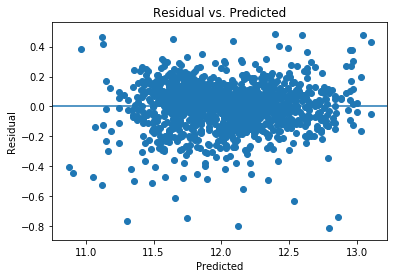

In [42]:
#Visual analysis
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [43]:
#Statistical analysis
from scipy.stats import bartlett, levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

#Null hypothesis: errors are homoscedastic
print("Bartlett test statistic value is {0:3g} and p value is {1:3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 1118.23 and p value is 3.60874e-245
Levene test statistic value is 981.787 and p value is 5e-186


Visually, the errors appear more or less homoscedastic. However, the errors are considered to be heteroscedastic statistically, using both the bartlett and levene tests.

_Assumption four: low multicollinearity_

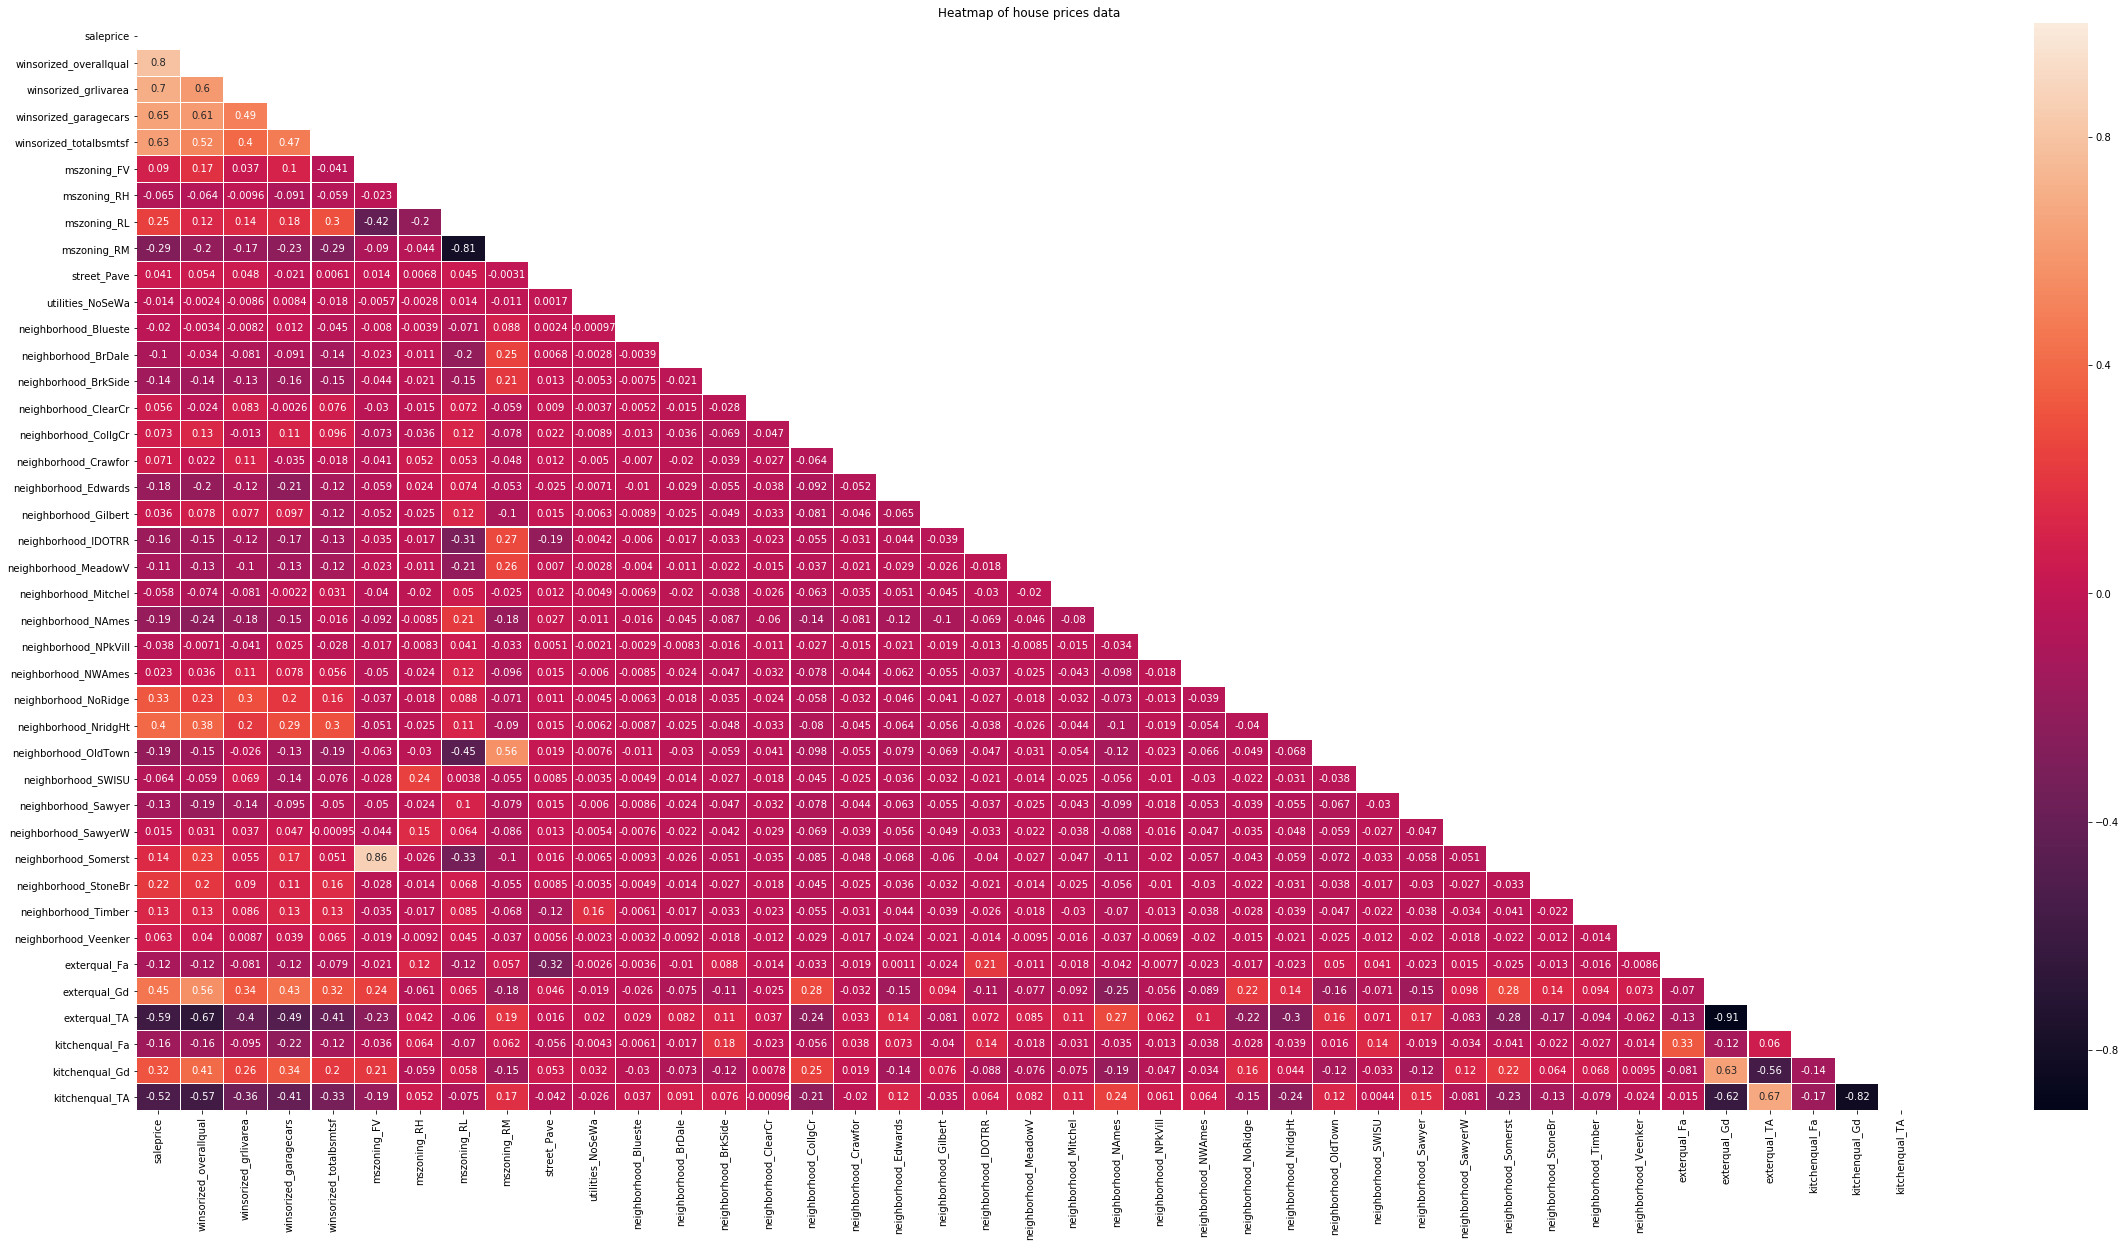

In [44]:
#Create a heatmap to show correlations
corr = houseprices_df[['saleprice', 'winsorized_overallqual', 'winsorized_grlivarea', 'winsorized_garagecars', 'winsorized_totalbsmtsf'] + dummy_column_names].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(40,20))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.2)
plt.title('Heatmap of house prices data')
plt.show()

Overall, multicollinearity appears low, with only a few exceptions out of many correlation values.

_Assumption five: error terms should be uncorrelated with one another_

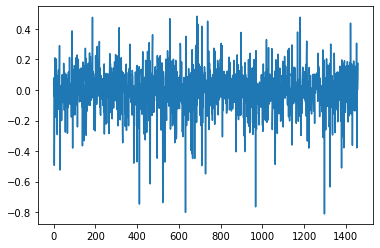

In [45]:
plt.plot(errors)
plt.show()

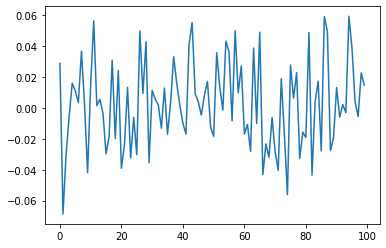

In [46]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors, nlags=100)
plt.plot(acf_data[1:])
plt.show()

The autocorrelation between errors in the houseprices regression model is very low (ranges approximately between -.06 and .06). This condition is met.

_Assumption six: features shouldn't be correlated with the errors_

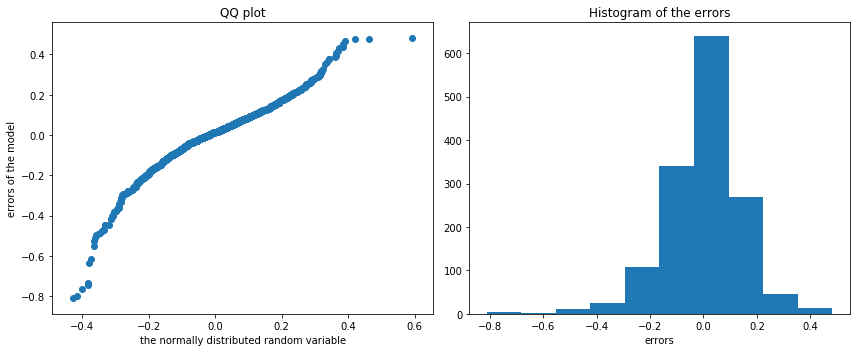

In [47]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [48]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 982.412065575776 and p value is 0.0
Normality test statistics is 269.5257254296814 and p value is 2.9732563662785146e-59


The regression model holds most Gauss Markov assumptions to be true (linear coefficients, error term equals zero, error terms uncorrelated with eachother). The conditions that were not exactly met were not far from the assumptions. For example, while the distribution of errors was not statistically normal, it was close visually.

Therefore, the model created here is valid.